In [1]:
import pandas as pd
import numpy as np

filename = "cars.csv"

dtypes = {
    "maker": str,
    "model": str,
    "mileage": float,
    "manufacture_year": float,
    "engine_displacement": float,
    "engine_power": float,
    "body_type": str,
    "color_slug": str,
    "stk_year": str,
    "transmission": str,
    "door_count": str,
    "seat_count": str,
    "fuel_type": str,
    "date_created": str,
    "date_last_seen": str,
    "price_eur": float}

df = pd.read_csv(filename, dtype=dtypes)
raw_shape = df.shape
print(f"Raw data has {raw_shape[0]} rows, and {raw_shape[1]} columns")
df.head()

Raw data has 3552912 rows, and 16 columns


,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,NaN,None,man,5,7,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,85.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


In [2]:
df = df[df["price_eur"] != 1295.34]
df = df[df["price_eur"] > 200.00]

print(df.isna().sum())

maker                   462087
model                  1008763
mileage                 174222
manufacture_year        257363
engine_displacement     513390
engine_power            355237
body_type              1122329
color_slug             2801332
stk_year               1133276
transmission            354416
door_count              214350
seat_count              352762
fuel_type              1493871
date_created                 0
date_last_seen               0
price_eur                    0
dtype: int64


In [3]:
df.describe()

,mileage,manufacture_year,engine_displacement,engine_power,price_eur
count,2.662996e+06,2.579855e+06,2.323828e+06,2.481981e+06,2.837218e+06
mean,1.036281e+05,2.005297e+03,1.972952e+03,9.950409e+01,2.035618e+06
std,3.071016e+05,5.402212e+01,1.661741e+03,4.956741e+01,2.266753e+09
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000400e+02
25%,1.586800e+04,2.005000e+03,1.398000e+03,6.900000e+01,4.480000e+03
50%,7.515000e+04,2.010000e+03,1.796000e+03,8.800000e+01,1.060000e+04
75%,1.450000e+05,2.014000e+03,1.997000e+03,1.150000e+02,1.881503e+04
max,9.999999e+06,2.016000e+03,3.200000e+04,1.504000e+03,2.706149e+12


In [4]:
df = df[df['fuel_type'].notna()]
df = pd.get_dummies(df,columns=["fuel_type"])

df = df[df['transmission'].notna()]
df = pd.get_dummies(df,columns=["transmission"])

#TODO: dopo la foresta
year_of_scepticism = 1970
average_years = df.loc[df["manufacture_year"] >= year_of_scepticism].\
groupby(["maker", "model"])["manufacture_year"].mean().round().rename("avg_manufacture_year").reset_index()

df = df.merge(average_years, how="left", on=["maker", "model"])
df.loc[df["manufacture_year"] < year_of_scepticism, "manufacture_year"] = np.nan
df["manufacture_year"] = df["manufacture_year"].fillna(df["avg_manufacture_year"])
df = df[df['manufacture_year'].notna()]

# df = df[df['seat_count'].notna()]
# df = df[df['door_count'].notna()]

features_to_fillna = ["door_count", "seat_count"]
for feature in features_to_fillna:
    df[feature] = pd.to_numeric(df[feature], errors="coerce") # transform to numeric
    replace_with = df[feature].median()                       # deduce the median
    df[feature].fillna(replace_with,inplace=True)             # replace null

df["seat_str"] = np.select(
    condlist=[
        (df["seat_count"] >= 0) & (df["seat_count"] < 4),
        (df["seat_count"] >= 4) & (df["seat_count"] < 6),
        (df["seat_count"] >= 6)],
    choicelist=[
        "small",
        "medium",
        "large",
        ],
    default="unknown")
df = pd.get_dummies(df,columns=["seat_str"])
df = df.drop(["seat_count"], axis=1)
df = df.drop(["door_count"], axis=1)

# Engine Power
scepticism = 50
average = df.loc[df["engine_power"] >= scepticism].\
groupby(["maker", "model"])["engine_power"].mean().round().rename("avg_engine_power").reset_index()

df = df.merge(average, how="left", on=["maker", "model"])
df.loc[df["engine_power"] < scepticism, "engine_power"] = np.nan
df["engine_power"] = df["engine_power"].fillna(df["avg_engine_power"])
df = df[df['engine_power'].notna()]

# Engine Disp
scepticism = 600
average = df.loc[df["engine_displacement"] >= scepticism].\
groupby(["maker", "model"])["engine_displacement"].mean().round().rename("avg_engine_displacement").reset_index()

df = df.merge(average, how="left", on=["maker", "model"])
df.loc[df["engine_displacement"] < scepticism, "engine_displacement"] = np.nan
df["engine_displacement"] = df["engine_displacement"].fillna(df["engine_displacement"])
df = df[df['engine_displacement'].notna()]

features_to_fillna = ["mileage" ] # , "engine_displacement","engine_power"
for feature in features_to_fillna:
    replace_with = df[feature].mean() # deduce the mean
    # replace_with = df[feature].median() # deduce the median 
    # replace_with = df[feature].mode() # deduce the mode
    df[feature].fillna(replace_with,inplace=True)
    
# let's transform str dates in datetimes and creare a new feature with the duration of the ad
df['date_created'] = pd.to_datetime(df['date_created']).dt.normalize()
df['date_last_seen'] = pd.to_datetime(df['date_last_seen']).dt.normalize()
df['ad_duration'] = (df['date_last_seen'] - df['date_created']).dt.days # new feature: how much last the ad

features_to_drop = ["model", "body_type", "color_slug", "stk_year", "avg_manufacture_year", "date_created", "date_last_seen", "avg_engine_power", "avg_engine_displacement"]
df = df.drop(features_to_drop, axis="columns")

In [5]:
# df.sort_values(by=['price_eur']).head(500)

In [6]:
# features_to_drop = ["date_created", "date_last_seen"]
# df = df.drop(features_to_drop, axis="columns")

df_with_maker = df[df['maker'].notna()]
df_with_maker.info(null_counts=True)

df_no_maker = df[df['maker'].isna()]
df_no_maker.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 654928 entries, 0 to 1011282
Data columns (total 14 columns):
maker                  654928 non-null object
mileage                654928 non-null float64
manufacture_year       654928 non-null float64
engine_displacement    654928 non-null float64
engine_power           654928 non-null float64
price_eur              654928 non-null float64
fuel_type_diesel       654928 non-null uint8
fuel_type_gasoline     654928 non-null uint8
transmission_auto      654928 non-null uint8
transmission_man       654928 non-null uint8
seat_str_large         654928 non-null uint8
seat_str_medium        654928 non-null uint8
seat_str_small         654928 non-null uint8
ad_duration            654928 non-null int64
dtypes: float64(5), int64(1), object(1), uint8(7)
memory usage: 44.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 212872 entries, 9 to 1011279
Data columns (total 14 columns):
maker                  0 non-null object
mileage              

In [27]:
from sklearn.model_selection import train_test_split

X = df_with_maker.drop("maker", axis=1).values
Y = df_with_maker["maker"].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

ACCURACY: TRAIN=0.9579 TEST=0.9157
LOG LOSS: 0.2977877450315094
[2, 3, 4, 1, 0, 12, 5, 6, 10, 8, 7, 9, 11]


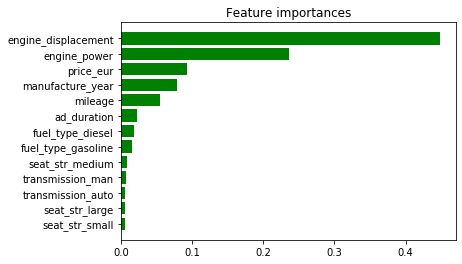

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline

forest = RandomForestClassifier(n_estimators=35, max_depth=25, random_state=False, max_features=0.6, min_samples_leaf=3, n_jobs=-1)

forest.fit(X_train, Y_train)

y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

y_pred_proba = forest.predict_proba(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))
print("LOG LOSS: "+str(log_loss(Y_test, y_pred_proba)))

importances = forest.feature_importances_
indices = list(np.argsort(importances))[::-1]
print(indices)

# print("Feature ranking:")
# for count, f in enumerate(indices):
#     print("{0}. feature {1} ({2})".format(count+1, f, importances[f]))

plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices], color="g", align="center")
plt.yticks(range(len(indices)), df_with_maker.iloc[:, 1:].columns[indices])
# plt.ylim([-1, len(indices)])
plt.gca().invert_yaxis()

#ACCURACY: TRAIN=0.9579 TEST=0.9157

In [32]:
from sklearn.metrics import classification_report

# from sklearn.ensemble import AdaBoostClassifier
# model3 = AdaBoostClassifier(random_state=1)
# model3.fit(X_train, Y_train)
# y_pred3 = model3.predict(X_test)

print(classification_report(Y_test, y_pred3))

/Users/danielesalerno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


               precision    recall  f1-score   support

         audi       0.00      0.00      0.00      8105
      bentley       0.23      0.51      0.32        37
          bmw       0.26      0.85      0.40      7535
    chevrolet       0.00      0.00      0.00       476
     chrysler       0.00      0.00      0.00       184
      citroen       0.00      0.00      0.00      2505
        dodge       0.00      0.00      0.00       134
         fiat       0.00      0.00      0.00      2490
         ford       0.00      0.00      0.00      5838
        honda       0.00      0.00      0.00       678
       hummer       0.00      0.00      0.00        23
      hyundai       0.00      0.00      0.00      1887
        isuzu       0.00      0.00      0.00        15
       jaguar       0.00      0.00      0.00       226
         jeep       0.00      0.00      0.00       407
          kia       0.00      0.00      0.00      1269
  lamborghini       0.05      0.62      0.09        24
       la

In [33]:
import xgboost as xgb
model5 = xgb.XGBClassifier(random_state=1)
model5.fit(X_train, Y_train)
y_pred5 = model5.predict(X_test)

print(classification_report(Y_test, y_pred5))

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model4 = GradientBoostingClassifier(random_state=1)
model4.fit(X_train, Y_train)
y_pred4 = model4.predict(X_test)

print(classification_report(Y_test, y_pred4))

In [9]:
df_no_maker = df_no_maker.drop('maker', axis=1)
prediction = forest.predict(df_no_maker)

df_no_maker.insert(0, 'maker', prediction)

frames = [df_with_maker, df_no_maker]
df = pd.concat(frames)
df.head()

,maker,mileage,manufacture_year,engine_displacement,engine_power,price_eur,fuel_type_diesel,fuel_type_gasoline,transmission_auto,transmission_man,seat_str_large,seat_str_medium,seat_str_small,ad_duration
0,ford,151000.0,2011.0,2000.0,103.0,10584.75,1,0,0,1,1,0,0,74
1,skoda,143476.0,2012.0,2000.0,81.0,8882.31,1,0,0,1,0,1,0,74
2,bmw,97676.0,2010.0,1995.0,85.0,12065.06,1,0,0,1,0,1,0,74
3,skoda,111970.0,2004.0,1200.0,64.0,2960.77,0,1,0,1,0,1,0,74
4,skoda,128886.0,2004.0,1200.0,64.0,2738.71,0,1,0,1,0,1,0,74
5,skoda,140932.0,2003.0,1200.0,64.0,1628.42,0,1,0,1,0,1,0,74
6,skoda,167220.0,2001.0,1400.0,74.0,2072.54,0,1,0,1,0,1,0,74
7,bmw,148500.0,2009.0,2000.0,130.0,10547.74,1,0,1,0,0,1,0,74
8,skoda,105389.0,2003.0,1900.0,81.0,4293.12,1,0,0,1,0,1,0,74
13,skoda,41250.0,1990.0,1300.0,52.0,370.10,0,1,0,1,0,1,0,74


In [10]:
df_exper = df.copy()

In [11]:
df_final = pd.get_dummies(df,columns=["maker"])
#df_final = df.drop("maker", axis=1)

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df_final.drop("price_eur", axis=1).values
Y = df_final["price_eur"].values

# from sklearn.preprocessing import MinMaxScaler

# mms = MinMaxScaler()
# X = mms.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)


ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))

MSE: 318846808.63792485
R2 score: 0.3555989719354905


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df_final.drop("price_eur", axis=1).values
Y = np.log1p(df_final["price_eur"].values)

# from sklearn.preprocessing import MinMaxScaler

# mms = MinMaxScaler()
# X = mms.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)


ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
#R2 score: 0.7612534633517375
df_final.shape[0]

MSE: 0.23031206240915947
R2 score: 0.7612534572531304


array([[1.51000e+05, 2.01100e+03, 2.00000e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.43476e+05, 2.01200e+03, 2.00000e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [9.76760e+04, 2.01000e+03, 1.99500e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.00000e+01, 2.01600e+03, 1.19700e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.53139e+05, 2.01000e+03, 2.00000e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.24500e+05, 2.00800e+03, 1.59500e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

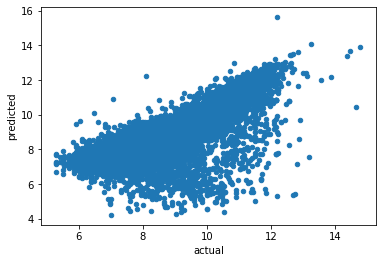

In [20]:
actual_predicted = pd.DataFrame({"predicted": ll.predict(X_test), 
                                  "actual": Y_test})

actual_predicted.plot.scatter(x="actual", y="predicted")

In [21]:
df_exper = df_final.copy()

from scipy import stats

df_exper = df_exper\
    .loc[:, lambda df: df.std() > 0.05]\
    .loc[lambda df: (np.abs(stats.zscore(df)) < 3).all(axis=1)]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df_exper.drop("price_eur", axis=1).values
Y = np.log1p(df_exper["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)


ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
#R2 score: 0.8920417998615465
df_exper.shape[0]

MSE: 0.08200045333657659
R2 score: 0.8920396717779099


234830

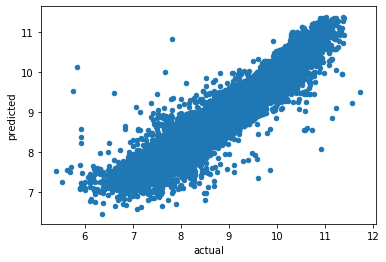

In [16]:
actual_predicted = pd.DataFrame({"predicted": Y_pred, 
                                  "actual": Y_test})

actual_predicted.plot.scatter(x="actual", y="predicted")